## Feature extraction with colour histograms

In [76]:
import pickle
import numpy as np
import cv2
import os
from sklearn.metrics.pairwise import cosine_similarity

# set working directory to paul

# get current working directory
print(os.getcwd())
dataset_path = "data/cifar-10-batches-py"


# install sklearn
# pip install -U scikit-learn

/Users/paulbojan/Documents/TU Wien/2.Semester/Machine Learning/assignments/ex3/ml-ex3/paul


In [77]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def extract_color_histogram(image, bins=(16, 16, 16), color_space='LAB'):
    if color_space == 'HSV':
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'LAB':
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    else:
        raise ValueError(f"Unsupported color space: {color_space}")

    hist = cv2.calcHist([converted_image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def load_cifar10_dataset(dataset_path, bins=(16, 16, 16), color_space='LAB'):
    data = []
    labels = []
    images = []
    for batch in range(1, 6):
        batch_file = os.path.join(dataset_path, f'data_batch_{batch}')
        batch_data = unpickle(batch_file)
        for image, label in zip(batch_data[b'data'], batch_data[b'labels']):
            image = image.reshape(3, 32, 32).transpose(1, 2, 0)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            hist = extract_color_histogram(image, bins=bins, color_space=color_space)
            data.append(hist)
            labels.append(label)
            images.append(image)
    return np.array(data), np.array(labels), images



dataset_path = "data/cifar-10-batches-py"

# 
bins = (8, 8, 8)  # Increase the number of bins
color_space = 'LAB'  # Use the LAB colour space


data, labels, images = load_cifar10_dataset(dataset_path, bins=bins, color_space=color_space)

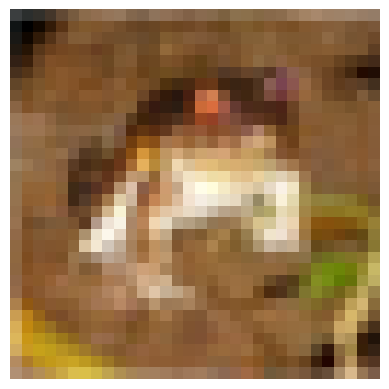

In [78]:
import matplotlib.pyplot as plt
import cv2

def display_image(image_data):
    # images has (3, 32, 32) (RGB) -> (32, 32, 3)
    image = image_data.reshape(3, 32, 32).transpose(1, 2, 0)
    # Convert from RGB to BGR for OpenCV display
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 
batch_file = os.path.join(dataset_path, 'data_batch_1')
batch_data = unpickle(batch_file)
first_image = batch_data[b'data'][0]

display_image(first_image)


### Exploring Histograms

In [79]:
# Import plt 
import matplotlib.pyplot as plt

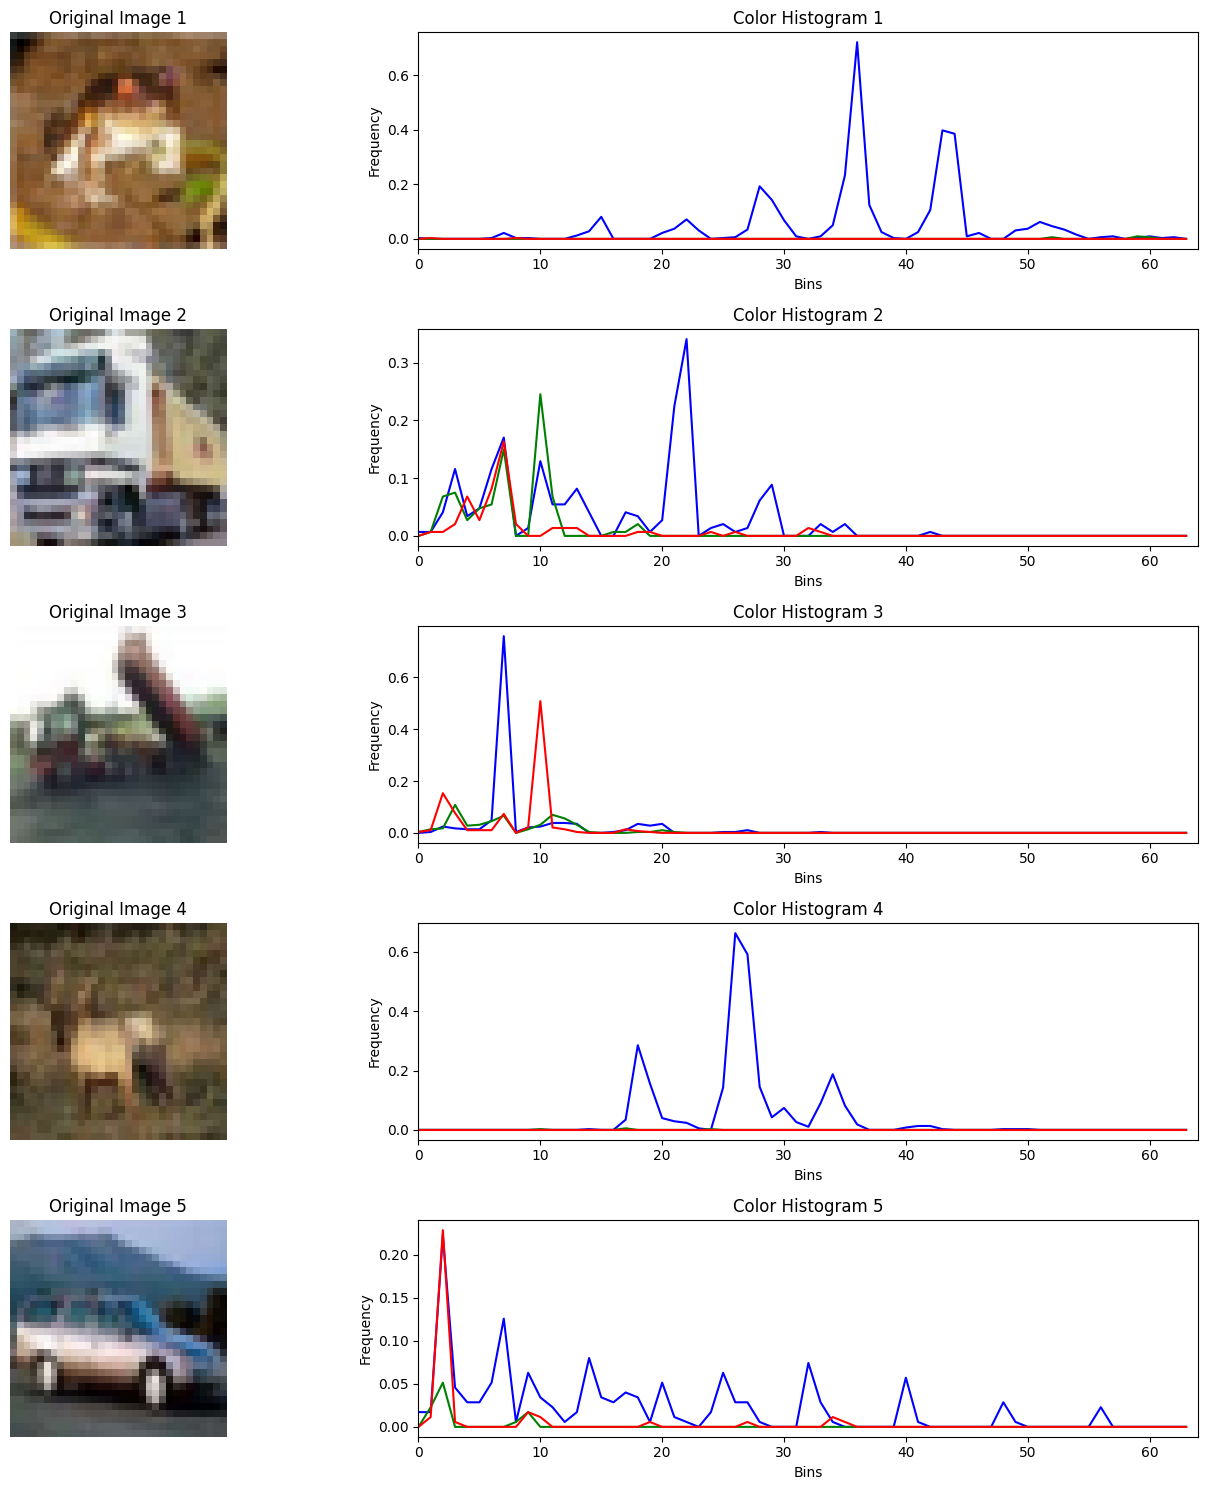

In [80]:
def plot_images_and_histograms(images, bins=(16, 16, 16), color_space='LAB'):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        plt.subplot(5, 2, 2 * i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image {i+1}")
        plt.axis('off')
        
        # Calculate colour histogram
        hist = extract_color_histogram(image, bins=bins, color_space=color_space)
        
        # Plot histogram 
        plt.subplot(5, 2, 2 * i + 2)
        colors = ('b', 'g', 'r')
        for j, col in enumerate(colors):
            hist_part = hist[j * bins[0] * bins[1]: (j + 1) * bins[0] * bins[1]]
            plt.plot(hist_part, color=col)
            plt.xlim([0, bins[0] * bins[1]])
        
        plt.title(f"Color Histogram {i+1}")
        plt.xlabel("Bins")
        plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

# Select five example images
example_images = images[:5]

# Plot images and histograms
#bins = (8, 8, 8)
plot_images_and_histograms(example_images, bins=bins, color_space='HSV')

###  Similarity

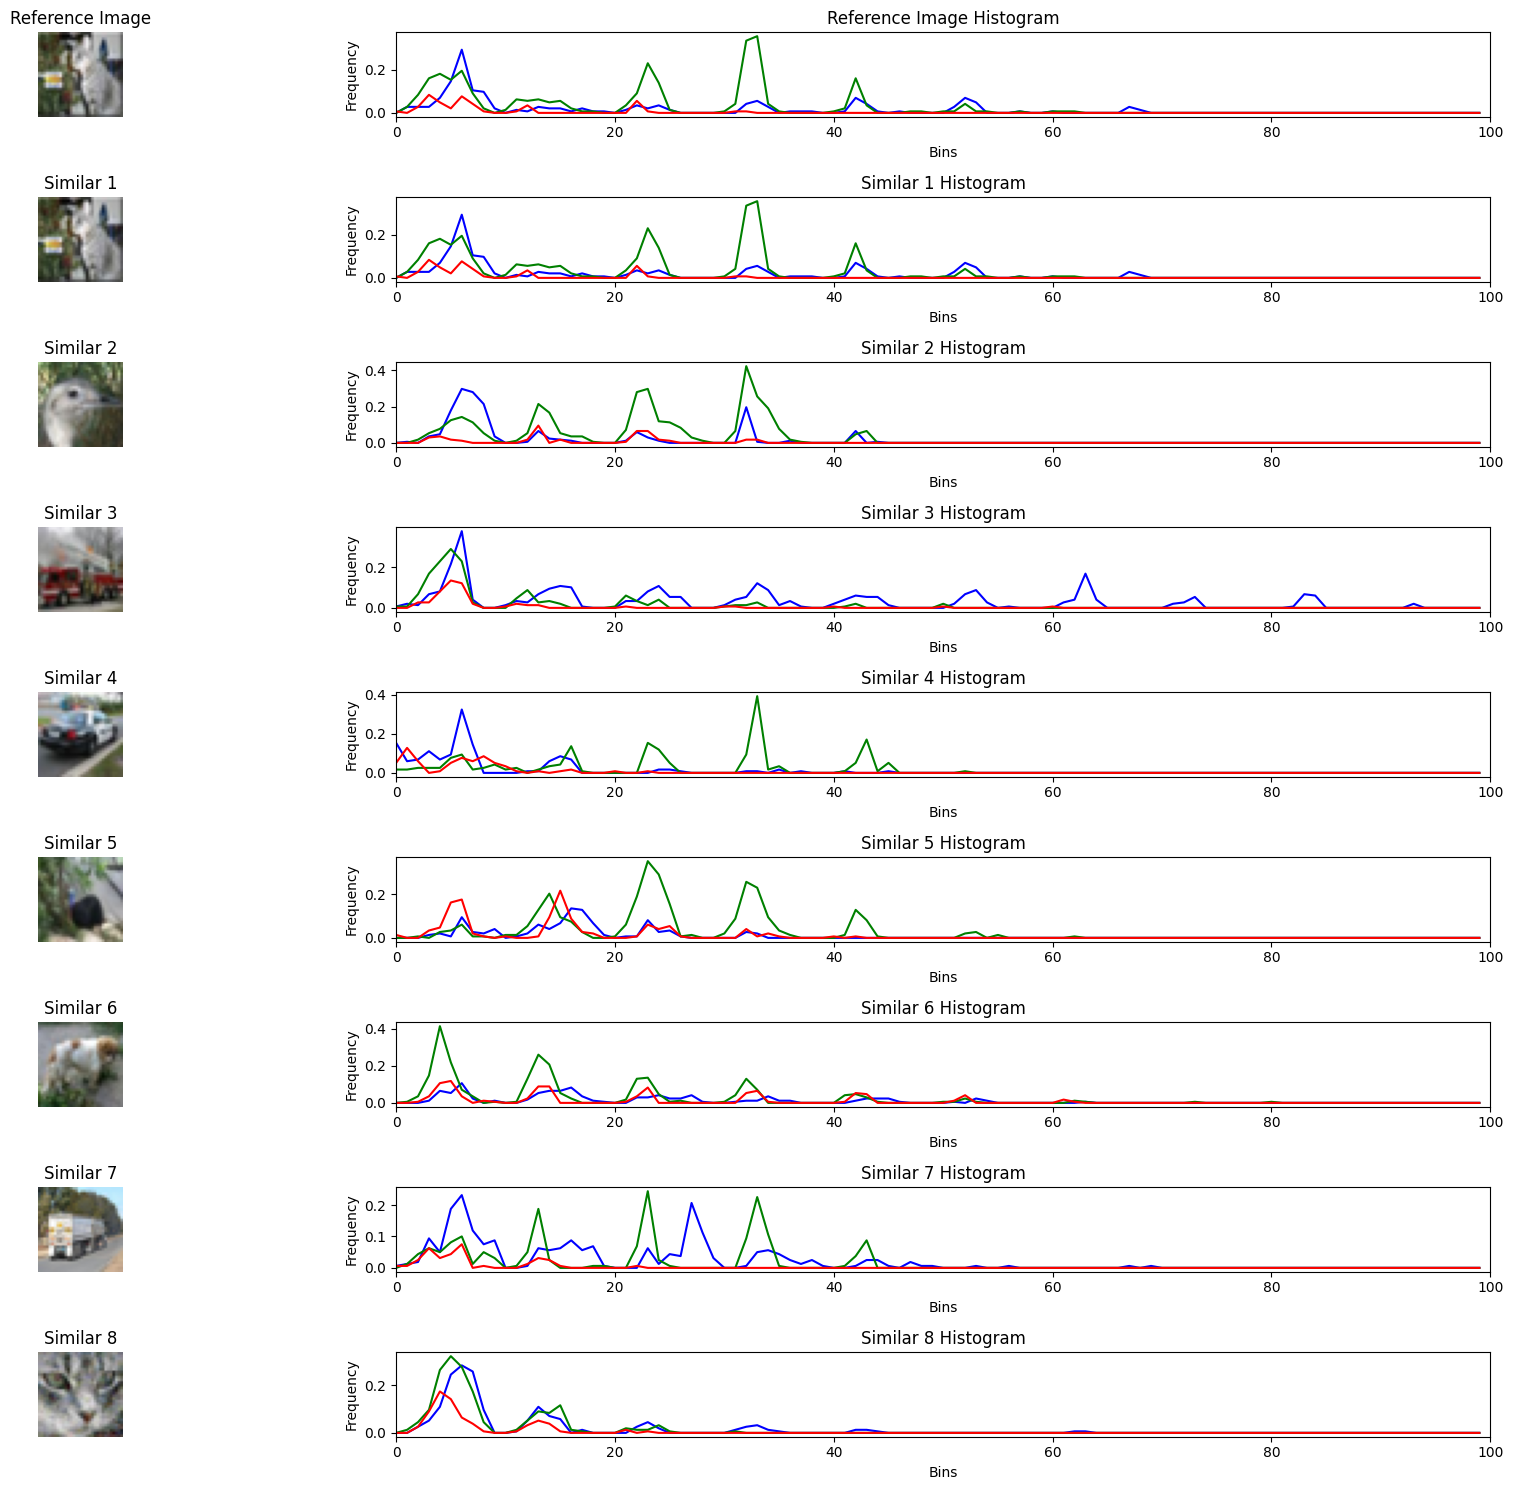

In [90]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

def extract_color_histogram(image, bins=(16, 16, 16), color_space='LAB'):
    if color_space == 'HSV':
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'LAB':
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    else:
        raise ValueError(f"Unsupported color space: {color_space}")

    hist = cv2.calcHist([converted_image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def find_similar_images(reference_image, data, labels, num_similar=8, bins=(16, 16, 16), color_space='LAB'):
    ref_hist = extract_color_histogram(reference_image, bins=bins, color_space=color_space)
    
    distances = []
    for i, hist in enumerate(data):
        dist = euclidean(ref_hist, hist)
        distances.append((dist, i))
    
    distances.sort()
    closest_indices = [index for _, index in distances[:num_similar]]
    
    similar_images = [images[i] for i in closest_indices]
    similar_labels = [labels[i] for i in closest_indices]
    
    return similar_images, similar_labels

def plot_images_and_histograms(reference_image, similar_images, similar_labels, bins=(16, 16, 16), color_space='LAB'):
    plt.figure(figsize=(20, 15))

    plt.subplot(len(similar_images) + 1, 2, 1)
    plt.imshow(cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB))
    plt.title("Reference Image")
    plt.axis('off')
    

    ref_hist = extract_color_histogram(reference_image, bins=bins, color_space=color_space)
    

    plt.subplot(len(similar_images) + 1, 2, 2)
    colors = ('b', 'g', 'r')
    for j, col in enumerate(colors):
        hist_part = ref_hist[j * bins[0] * bins[1]: (j + 1) * bins[0] * bins[1]]
        plt.plot(hist_part, color=col)
        plt.xlim([0, bins[0] * bins[1]])
    plt.title("Reference Image Histogram")
    plt.xlabel("Bins")
    plt.ylabel("Frequency")
    

    for i, (image, label) in enumerate(zip(similar_images, similar_labels), start=1):
        plt.subplot(len(similar_images) + 1, 2, 2 * i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Similar {i}")
        plt.axis('off')
        
        hist = extract_color_histogram(image, bins=bins, color_space=color_space)
        
        plt.subplot(len(similar_images) + 1, 2, 2 * i + 2)
        for j, col in enumerate(colors):
            hist_part = hist[j * bins[0] * bins[1]: (j + 1) * bins[0] * bins[1]]
            plt.plot(hist_part, color=col)
            plt.xlim([0, bins[0] * bins[1]])
        plt.title(f"Similar {i} Histogram")
        plt.xlabel("Bins")
        plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

bins = (10, 10, 10)
color_space = 'HSV'

dataset_path = "data/cifar-10-batches-py"
data, labels, images = load_cifar10_dataset(dataset_path, bins=bins, color_space=color_space)

# select reference image
reference_image = images[78]

# Find similar images
similar_images, similar_labels = find_similar_images(reference_image, data, labels, num_similar=8, bins=bins, color_space=color_space)

# Show the reference image and the similar images with their histograms

plot_images_and_histograms(reference_image, similar_images, similar_labels, bins=bins, color_space=color_space)


## Experiments



**More bins for the histogram**: 
Increasing the number of bins can improve the resolution of the colour histogram. Instead of 8 bins per channel, you could use 16 or even 32.


**Other colour spaces**:
In addition to the HSV colour space, you could try out other colour spaces such as LAB or YUV to see if they deliver better results.


**Combination of features**
In addition to colour histograms, you could also include other features such as texture features (e.g. Gabor filters, Haralick features) or shape features.

## Application of shallow algorithms

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split the dataset into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

# scale the features to the range [0, 1] 
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)



## train and evaluate the shallow 

In [92]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


### RF

In [96]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainX, trainY)
rf_predictions = rf.predict(testX)
print("Random Forest Accuracy:", accuracy_score(testY, rf_predictions))
print("Random Forest Classification Report:\n", classification_report(testY, rf_predictions))



Random Forest Accuracy: 0.4072
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.52      0.50      1235
           1       0.41      0.52      0.46      1212
           2       0.36      0.30      0.33      1270
           3       0.32      0.33      0.32      1291
           4       0.43      0.40      0.41      1182
           5       0.33      0.25      0.28      1263
           6       0.44      0.51      0.47      1219
           7       0.37      0.36      0.37      1259
           8       0.47      0.50      0.48      1280
           9       0.42      0.40      0.41      1289

    accuracy                           0.41     12500
   macro avg       0.40      0.41      0.40     12500
weighted avg       0.40      0.41      0.40     12500



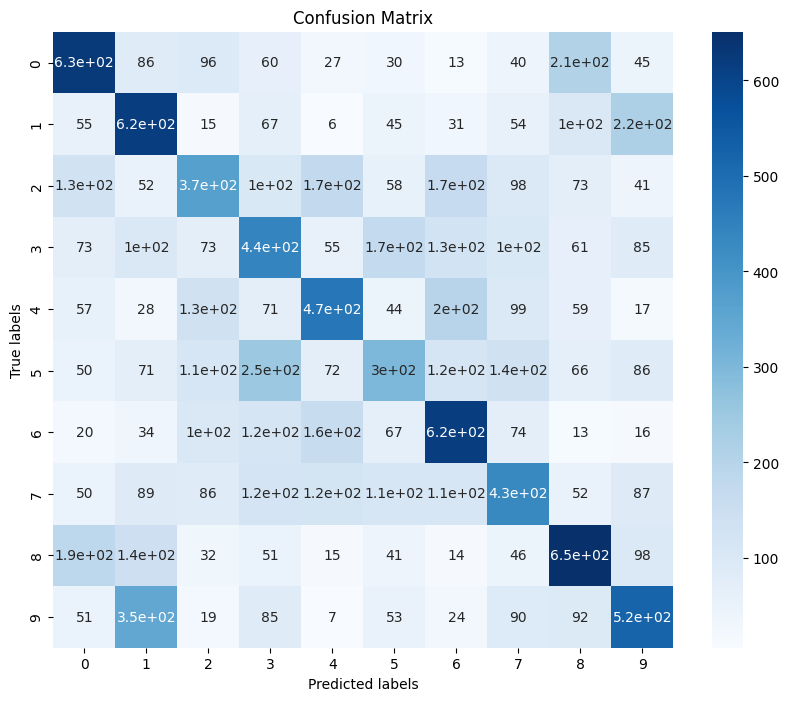

In [95]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

rf_cm = confusion_matrix(testY, rf_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(rf_cm, annot=True, cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### SVM

In [20]:
svm = SVC(kernel='linear')
svm.fit(trainX, trainY)
svm_predictions = svm.predict(testX)
print("SVM Accuracy:", accuracy_score(testY, svm_predictions))
print("SVM Classification Report:\n", classification_report(testY, svm_predictions))
